In [37]:
#importing the required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [5]:
# Load the image
image_path = "/content/images.jpeg"
image = cv2.imread(image_path)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [6]:
#  Segment the Image
# Define color ranges for green and orange
green_lower = np.array([25, 100, 100])
green_upper = np.array([85, 255, 255])
orange_lower = np.array([10, 100, 100])
orange_upper = np.array([25, 255, 255])

# Create masks for green and orange
green_mask = cv2.inRange(hsv, green_lower, green_upper)
orange_mask = cv2.inRange(hsv, orange_lower, orange_upper)

# Convert masks to color images for visualization
green_segmented = cv2.bitwise_and(image, image, mask=green_mask)
orange_segmented = cv2.bitwise_and(image, image, mask=orange_mask)

In [7]:
#  Histogram Equalization on Color Image using CLAHE
# Convert the image to YUV color space
yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
y_channel, u_channel, v_channel = cv2.split(yuv_image)

# Apply CLAHE to the Y channel
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_y = clahe.apply(y_channel)

# Merge the channels back
equalized_yuv = cv2.merge((clahe_y, u_channel, v_channel))
equalized_color = cv2.cvtColor(equalized_yuv, cv2.COLOR_YUV2BGR)

In [8]:
#  Spatial Segmentation
# Reshape the image into a 2D array of pixels
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define criteria and apply k-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2  # Number of clusters
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back the clustered pixels to image format
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()].reshape(image.shape)

In [9]:
#  Edge Detection (on Spatially Segmented Image)
# Convert the segmented image to grayscale for edge detection
gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_segmented, 50, 150)

In [10]:
#  Identify Objects of Interest (Contours for green and orange)
green_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
orange_contours, _ = cv2.findContours(orange_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [12]:
 # Extract Features from Each Object
def extract_features(contour):
    features = {}
    features['Area'] = cv2.contourArea(contour)
    features['Perimeter'] = cv2.arcLength(contour, True)
    x, y, w, h = cv2.boundingRect(contour)
    features['BoundingBox'] = (x, y, w, h)
    M = cv2.moments(contour)
    features['Centroid'] = (int(M['m10']/M['m00']), int(M['m01']/M['m00'])) if M['m00'] != 0 else (None, None)
    return features

In [13]:
# Extract features for green and orange
green_features = [extract_features(contour) for contour in green_contours if cv2.contourArea(contour) > 500]
orange_features = [extract_features(contour) for contour in orange_contours if cv2.contourArea(contour) > 500]

# Print extracted features
print("Green Apples Features:")
for i, features in enumerate(green_features):
    print(f"Object {i+1}: {features}")

print("\nOranges Features:")
for i, features in enumerate(orange_features):
    print(f"Object {i+1}: {features}")

Green Apples Features:
Object 1: {'Area': 3229.0, 'Perimeter': 232.16652059555054, 'BoundingBox': (236, 100, 68, 61), 'Centroid': (270, 129)}
Object 2: {'Area': 3601.5, 'Perimeter': 380.14927554130554, 'BoundingBox': (59, 55, 91, 82), 'Centroid': (101, 93)}
Object 3: {'Area': 1127.5, 'Perimeter': 203.09545266628265, 'BoundingBox': (169, 53, 63, 38), 'Centroid': (205, 72)}
Object 4: {'Area': 1356.0, 'Perimeter': 175.8822499513626, 'BoundingBox': (0, 32, 53, 48), 'Centroid': (19, 49)}
Object 5: {'Area': 1177.5, 'Perimeter': 160.1248905658722, 'BoundingBox': (99, 16, 58, 33), 'Centroid': (128, 30)}

Oranges Features:
Object 1: {'Area': 13543.5, 'Perimeter': 977.4772635698318, 'BoundingBox': (113, 27, 183, 132), 'Centroid': (193, 92)}
Object 2: {'Area': 7078.0, 'Perimeter': 615.6711342334747, 'BoundingBox': (0, 25, 112, 131), 'Centroid': (45, 94)}


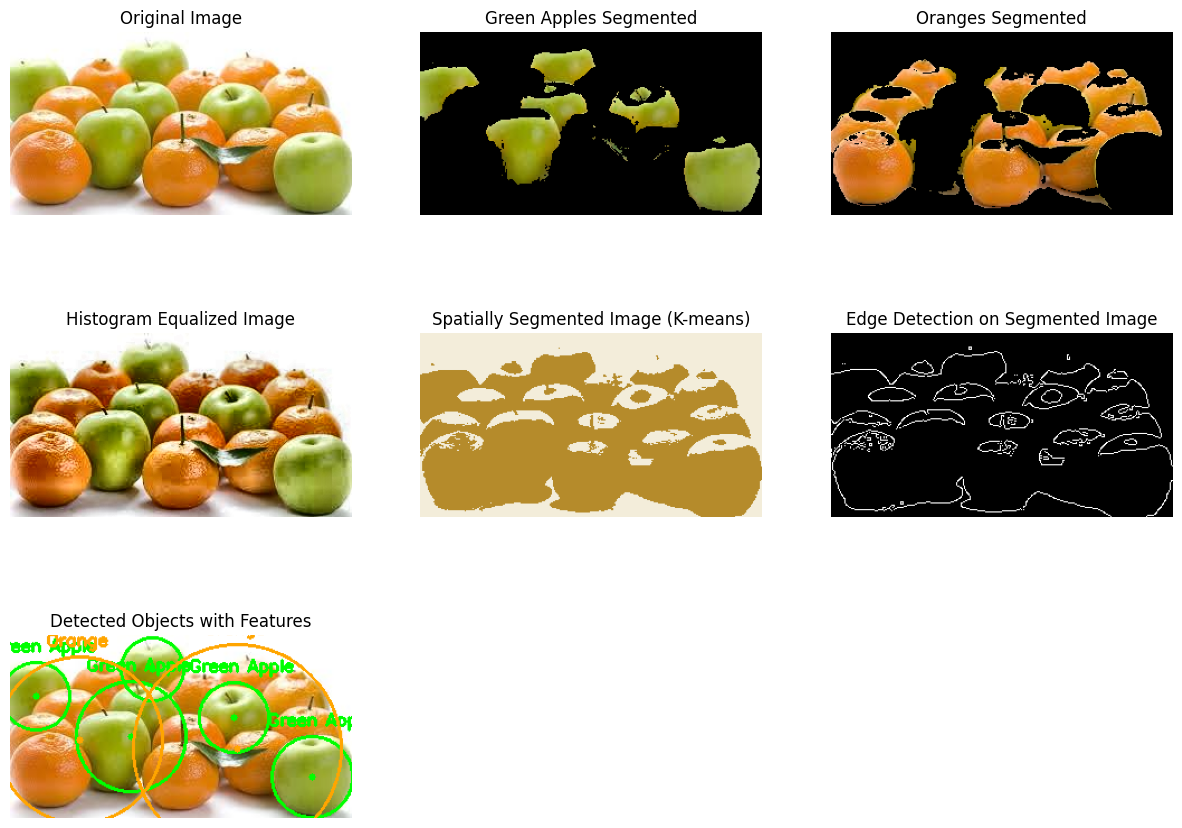

In [14]:
#  Analyze and Use the Features
# Example reference feature (you can adjust or calculate this based on actual reference)
reference_features = {'Area': 500, 'Perimeter': 100, 'BoundingBox': (0, 0, 0, 0), 'Centroid': (0, 0)}

# Draw contours and features
output_image = image.copy()

for contour in green_contours:
    if cv2.contourArea(contour) > 500:
        features = extract_features(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(output_image, center, radius, (0, 255, 0), 2)
        cv2.circle(output_image, center, 3, (0, 255, 0), -1)
        cv2.putText(output_image, 'Green Apple', (center[0] - 40, center[1] - radius - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

for contour in orange_contours:
    if cv2.contourArea(contour) > 500:
        features = extract_features(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(output_image, center, radius, (0, 165, 255), 2)
        cv2.circle(output_image, center, 3, (0, 165, 255), -1)
        cv2.putText(output_image, 'Orange', (center[0] - 30, center[1] - radius - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 165, 255), 2)

# Display the intermediate results for segmentation and edge detection
plt.figure(figsize=(15, 15))

plt.subplot(4, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(4, 3, 2)
plt.imshow(cv2.cvtColor(green_segmented, cv2.COLOR_BGR2RGB))
plt.title("Green Apples Segmented")
plt.axis('off')

plt.subplot(4, 3, 3)
plt.imshow(cv2.cvtColor(orange_segmented, cv2.COLOR_BGR2RGB))
plt.title("Oranges Segmented")
plt.axis('off')

plt.subplot(4, 3, 4)
plt.imshow(cv2.cvtColor(equalized_color, cv2.COLOR_BGR2RGB))
plt.title("Histogram Equalized Image")
plt.axis('off')

plt.subplot(4, 3, 5)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("Spatially Segmented Image (K-means)")
plt.axis('off')

# Display edge detection result after spatial segmentation
plt.subplot(4, 3, 6)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
plt.title("Edge Detection on Segmented Image")
plt.axis('off')

# Display the final output image with contours
plt.subplot(4, 3, 7)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects with Features")
plt.axis('off')

plt.show()

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Function to extract features from an object
def extract_features(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features = []

    for cnt in contours:
        # Compute area, centroid, and average color intensity
        area = cv2.contourArea(cnt)
        M = cv2.moments(cnt)
        centroid_x = int(M['m10'] / M['m00']) if M['m00'] != 0 else 0
        centroid_y = int(M['m01'] / M['m00']) if M['m00'] != 0 else 0

        # Bounding box and aspect ratio (additional feature)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h if h != 0 else 0

        # Calculate average color intensity within the segmented region
        mask_rgb = cv2.bitwise_and(image, image, mask=mask)
        average_color = np.mean(mask_rgb, axis=(0, 1))

        features.append({
            'area': area,
            'centroid': (centroid_x, centroid_y),
            'aspect_ratio': aspect_ratio,
            'average_color': average_color,
            'bounding_box': (x, y, w, h)  # Store bounding box for drawing
        })

    return features

In [33]:
# Load the reference object (replace with your reference object image path)
reference_image = cv2.imread(r"/content/images.jpeg")
reference_hsv = cv2.cvtColor(reference_image, cv2.COLOR_BGR2HSV)

# Define the range for the reference object in HSV (adjust as needed)
reference_lower = np.array([5, 100, 100])
reference_upper = np.array([20, 255, 255])  # Example range for red apple
reference_mask = cv2.inRange(reference_hsv, reference_lower, reference_upper)

# Extract features from the reference object
reference_features = extract_features(reference_image, reference_mask)

# Display reference features for debugging (optional)
print("Reference Features:")
for feat in reference_features:
    print(feat)


Reference Features:
{'area': 59.0, 'centroid': (108, 142), 'aspect_ratio': 2.111111111111111, 'average_color': array([14.24400207, 44.44372708, 70.91857963]), 'bounding_box': (96, 137, 19, 9)}
{'area': 2.0, 'centroid': (226, 89), 'aspect_ratio': 1.0, 'average_color': array([14.24400207, 44.44372708, 70.91857963]), 'bounding_box': (225, 89, 3, 3)}
{'area': 0.0, 'centroid': (0, 0), 'aspect_ratio': 1.0, 'average_color': array([14.24400207, 44.44372708, 70.91857963]), 'bounding_box': (164, 77, 1, 1)}
{'area': 0.0, 'centroid': (0, 0), 'aspect_ratio': 1.0, 'average_color': array([14.24400207, 44.44372708, 70.91857963]), 'bounding_box': (162, 77, 1, 1)}
{'area': 0.0, 'centroid': (0, 0), 'aspect_ratio': 1.0, 'average_color': array([14.24400207, 44.44372708, 70.91857963]), 'bounding_box': (174, 74, 1, 1)}
{'area': 19.5, 'centroid': (260, 68), 'aspect_ratio': 1.8, 'average_color': array([14.24400207, 44.44372708, 70.91857963]), 'bounding_box': (257, 67, 9, 5)}
{'area': 0.0, 'centroid': (0, 0), '

In [34]:
# Load the target image
target_image = cv2.imread(r"/content/apple orange.jpg")
target_hsv = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)

# Define your masks for apples, oranges, and green objects
# Mask for apples (assuming red color)
mask_apple = cv2.inRange(target_hsv, np.array([0, 100, 100]), np.array([30, 255, 255]))  # Adjusted range for red apples

# Mask for oranges (assuming orange color)
mask_orange = cv2.inRange(target_hsv, np.array([10, 100, 100]), np.array([25, 255, 255]))  # Orange range

# Mask for green objects (adjusting the range to exclude green apples)
mask_green = cv2.inRange(target_hsv, np.array([40, 50, 50]), np.array([80, 150, 150]))

# Combine the masks for apples and oranges
target_combined_mask = cv2.bitwise_or(mask_apple, mask_orange)

# Extract features from the target image
target_features = extract_features(target_image, target_combined_mask)

# Set threshold values for matching (adjust as needed)
threshold_apple = 3500.0  # Define a suitable threshold for apple matching
threshold_orange = 3000.0  # Define a suitable threshold for orange matching
threshold_green = 2000.0  # Define a suitable threshold for green object matching

In [39]:


# Compare features for object detection
for i, target_feat in enumerate(target_features):
    best_match_apple = None
    best_distance_apple = float('inf')
    best_match_orange = None
    best_distance_orange = float('inf')
    best_match_green = None
    best_distance_green = float('inf')

    for ref_feat in reference_features:
        # Calculate similarity measures using Euclidean distance for feature comparison
        distance = np.sqrt(
            (target_feat['area'] - ref_feat['area']) ** 2 +
            (target_feat['centroid'][0] - ref_feat['centroid'][0]) ** 2 +
            (target_feat['centroid'][1] - ref_feat['centroid'][1]) ** 2 +
            (target_feat['aspect_ratio'] - ref_feat['aspect_ratio']) ** 2 +
            np.sum((target_feat['average_color'] - ref_feat['average_color']) ** 2)
        )

        # Compare with apple reference
        if distance < best_distance_apple:
            best_distance_apple = distance
            best_match_apple = ref_feat

        # Compare with orange reference
        if distance < best_distance_orange:
            best_distance_orange = distance
            best_match_orange = ref_feat

        # Compare with green reference (if you have a green reference)
        if distance < best_distance_green:
            best_distance_green = distance
            best_match_green = ref_feat

    # Label assignment based on closest match and thresholds
    if best_distance_apple < threshold_apple and best_distance_apple < best_distance_orange and best_distance_apple < best_distance_green:
        label = 'Apple'
    elif best_distance_orange < threshold_orange and best_distance_orange < best_distance_green:
        label = 'Orange'
    elif best_distance_green < threshold_green:
        label = 'Object matched'
    else:
        label = 'No Match'

    # Draw bounding box, centroid, and label on the target image
    x, y, w, h = target_feat['bounding_box']  # Use the bounding box stored during feature extraction
    cv2.rectangle(target_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.circle(target_image, target_feat['centroid'], 5, (255, 0, 0), -1)
    cv2.putText(target_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)



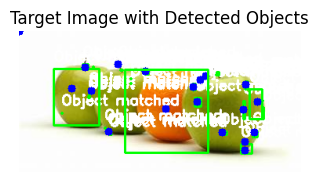

In [36]:
# Display the final image with features and labels
target_image_rgb_final = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))

# Plot target image
plt.subplot(1, 4, 1)
plt.imshow(target_image_rgb_final)
plt.title('Target Image with Detected Objects')
plt.axis('off')





plt.tight_layout()
plt.show()

In [30]:
import pandas as pd

# Create a list to store the labeled data
labeled_data = []

# Set threshold value for matching (adjust as needed)
threshold_value = 3500.0  # Example threshold

# Compare features for object detection and label them
for i, target_feat in enumerate(target_features):
    best_match = None
    best_distance = float('inf')
    label = 'No Match'  # Default label for no match

    for ref_feat in reference_features:
        # Calculate Euclidean distance for feature comparison
        distance = np.sqrt(
            (target_feat['area'] - ref_feat['area']) ** 2 +
            (target_feat['centroid'][0] - ref_feat['centroid'][0]) ** 2 +
            (target_feat['centroid'][1] - ref_feat['centroid'][1]) ** 2 +
            (target_feat['aspect_ratio'] - ref_feat['aspect_ratio']) ** 2 +
            np.sum((target_feat['average_color'] - ref_feat['average_color']) ** 2)
        )

        if distance < best_distance:
            best_distance = distance
            best_match = ref_feat

    # Set label based on threshold and best match
    if best_distance < threshold_value:
        label = 'Matched Object'  # You can modify this to a specific object name

    # Store features and label for the dataset
    labeled_data.append({
        'Object_ID': i,
        'Area': target_feat['area'],
        'Centroid_X': target_feat['centroid'][0],
        'Centroid_Y': target_feat['centroid'][1],
        'Aspect_Ratio': target_feat['aspect_ratio'],
        'Average_Color': target_feat['average_color'].tolist(),  # Convert numpy array to list for storage
        'Label': label
    })

# Convert labeled data to DataFrame for easy manipulation
labeled_df = pd.DataFrame(labeled_data)

# Save the labeled dataset to a CSV file
labeled_df.to_csv('labeled_dataset.csv', index=False)

print("Labeled dataset created and saved as 'labeled_dataset.csv'")

Labeled dataset created and saved as 'labeled_dataset.csv'
